# Setup

In [1]:
pwd # should be <your_root_dir>/f-dre/notebooks

'/atlas/u/madeline/f-dre/notebooks'

In [2]:
cd ..

/atlas/u/madeline/f-dre


In [3]:
import math
import sklearn.metrics.pairwise as sk
from sklearn.svm import SVC
from cvxopt import matrix, solvers
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.flows.models.maf import MAF

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1) Dataset loading (run either (i) or (ii) -- not both)

## (i) EITHER: Load existing data from repo

In [7]:
train_data = np.load('data/uci_wine_quality/train.npz')
X = train_data['x']
y = train_data['y']

test_data = np.load('data/uci_wine_quality/test.npz')
Z = test_data['x']
u = test_data['y']

## (ii) OR: Generate new dataset
Reference: https://papers.nips.cc/paper/2006/file/a2186aa7c086b46ad4e8bf81e2a3a19b-Paper.pdf

If \\(s\\) is indicator variable representing whether or not a data point \\(x\\) is selected, then \\(p(s \mid x) \propto\exp(-\sigma \lVert x - \bar{x}\rVert^2)\\).

In [6]:
# import pandas as pd
# import random
# from sklearn.model_selection import train_test_split

# # load data for red and white wines
# white_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
# red_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
# df = pd.concat([white_df, red_df])

# # create labels
# df.loc[df['quality'] <= 5, 'quality'] = 0
# df.loc[df['quality'] > 5, 'quality'] = 1

# # parameters
# test_perc = 0.7 # size of held-out test data
# sigma = 1/20

# # get number of features + label column
# attr_cols = list(df.columns[:len(df.columns) - 1])
# num_classes = len(attr_cols)
# label_col = 'quality'

# train_df, test_df = train_test_split(df, test_size=test_perc)

# n_samples = len(df)
# x_mean = np.mean(train_df.to_numpy()[:, :num_classes], axis=0)
# prob_inclusion = 100 * np.exp(-sigma * np.linalg.norm(train_df.to_numpy()[:, :num_classes] - x_mean, axis=1)**2)
# idxs = np.arange(len(train_df))
# selected = np.array(np.nonzero(idxs * (np.random.random(size=len(train_df)) <= prob_inclusion))[0])
# biased_df = train_df.iloc[idxs[selected]]

# # normalize train data
# data = biased_df.to_numpy()[:, :num_classes]
# X = (data - np.mean(data, axis=0))/np.std(data, axis=0)
# y = biased_df.to_numpy()[:, num_classes]

# # normalize test data
# data = test_df.to_numpy()[:, :num_classes]
# Z = (data - np.mean(data, axis=0))/np.std(data, axis=0)
# u = test_df.to_numpy()[:, num_classes]

# 2) Load config

In [9]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

In [10]:
config_file = 'src/configs/flows/uci_wine_quality/maf.yaml'
with open(config_file) as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

# 3) Load flow

In [11]:
def load_flow(restore_file):
    model = MAF(config.model.n_blocks, 
                config.model.input_size, 
                config.model.hidden_size, 
                config.model.n_hidden, 
                None, 
                config.model.activation_fn, 
                config.model.input_order, 
                batch_norm=True)
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cpu')
    model.load_state_dict(state['model_state'])
    model = model.to('cpu')
    model.eval()
    return model

In [13]:
device = 'cpu'
restore_dir = f'src/flows/results/uci_wine_quality_maf'
flow = load_flow(restore_dir)

# 4) Define KLIEP function
Reference: https://github.com/srome/pykliep

In [14]:
import numpy as np
import warnings
import sklearn.metrics.pairwise as sk

class DensityRatioEstimator:
    """
    Class to accomplish direct density estimation implementing the original KLIEP 
    algorithm from Direct Importance Estimation with Model Selection
    and Its Application to Covariate Shift Adaptation by Sugiyama et al. 
    
    The training set is distributed via 
                                            train ~ p(x)
    and the test set is distributed via 
                                            test ~ q(x).
                                            
    The KLIEP algorithm and its variants approximate w(x) = q(x) / p(x) directly. The predict function returns the
    estimate of w(x). The function w(x) can serve as sample weights for the training set during
    training to modify the expectation function that the model's loss function is optimized via,
    i.e.
    
            E_{x ~ w(x)p(x)} loss(x) = E_{x ~ q(x)} loss(x).
    
    Usage : 
        The fit method is used to run the KLIEP algorithm using LCV and returns value of J 
        trained on the entire training/test set with the best sigma found. 
        Use the predict method on the training set to determine the sample weights from the KLIEP algorithm.
    """
    
    def __init__(self, max_iter=2000, num_params=[.1,.2], epsilon=1e-4, cv=3, sigmas=[.01,.1,.5, 1], random_state=None, verbose=0):
        """ 
        Direct density estimation using an inner LCV loop to estimate the proper model. Can be used with sklearn
        cross validation methods with or without storing the inner CV. To use a standard grid search.
        
        
        max_iter : Number of iterations to perform
        num_params : List of number of test set vectors used to construct the approximation for inner LCV.
                     Must be a float. Original paper used 10%, i.e. =.1
        sigmas : List of sigmas to be used in inner LCV loop.
        epsilon : Additive factor in the iterative algorithm for numerical stability.
        """
        self.max_iter = max_iter
        self.num_params = num_params
        self.epsilon = epsilon
        self.verbose = verbose
        self.sigmas = sigmas
        self.cv = cv
        self.random_state = 0
        
    def fit(self, X_train, X_test, alpha_0=None):
        """ Uses cross validation to select sigma as in the original paper (LCV).
            In a break from sklearn convention, y=X_test.
            The parameter cv corresponds to R in the original paper.
            Once found, the best sigma is used to train on the full set."""
        
        # LCV loop, shuffle a copy in place for performance.
        cv = self.cv
        chunk = int(X_test.shape[0]/float(cv))
        if self.random_state is not None:
            np.random.seed(self.random_state)
        X_test_shuffled = X_test.copy()
        np.random.shuffle(X_test_shuffled)
        
        j_scores = {}
        
        if type(self.sigmas) != list:
            self.sigmas = [self.sigmas]
        
        if type(self.num_params) != list:
            self.num_params = [self.num_params]
        
        if len(self.sigmas) * len(self.num_params) > 1:
            # Inner LCV loop
            for num_param in self.num_params:
                for sigma in self.sigmas:
                    j_scores[(num_param,sigma)] = np.zeros(cv)
                    for k in range(1,cv+1):
                        if self.verbose > 0:
                            print('Training: sigma: %s    R: %s' % (sigma, k))
                        X_test_fold = X_test_shuffled[(k-1)*chunk:k*chunk,:] 
                        j_scores[(num_param,sigma)][k-1] = self._fit(X_train=X_train, 
                                                         X_test=X_test_fold,
                                                         num_parameters = num_param,
                                                         sigma=sigma)
                    j_scores[(num_param,sigma)] = np.mean(j_scores[(num_param,sigma)])

            sorted_scores = sorted([x for x in j_scores.items() if np.isfinite(x[1])], key=lambda x :x[1], reverse=True)
            if len(sorted_scores) == 0:
                warnings.warn('LCV failed to converge for all values of sigma.')
                return self
            self._sigma = sorted_scores[0][0][1]
            self._num_parameters = sorted_scores[0][0][0]
            self._j_scores = sorted_scores
        else:
            self._sigma = self.sigmas[0]
            self._num_parameters = self.num_params[0]
            # best sigma
        self._j = self._fit(X_train=X_train, X_test=X_test_shuffled, num_parameters=self._num_parameters, sigma=self._sigma)

        return self # Compatibility with sklearn
        
    def _fit(self, X_train, X_test, num_parameters, sigma, alpha_0=None):
        """ Fits the estimator with the given parameters w-hat and returns J"""
        
        num_parameters = num_parameters
        
        if type(num_parameters) == float:
            num_parameters = int(X_test.shape[0] * num_parameters)

        self._select_param_vectors(X_test=X_test, 
                                   sigma=sigma,
                                   num_parameters=num_parameters)
        
        X_train = self._reshape_X(X_train)
        X_test = self._reshape_X(X_test)
        
        if alpha_0 is None:
            alpha_0 = np.ones(shape=(num_parameters,1))/float(num_parameters)
        
        self._find_alpha(X_train=X_train,
                         X_test=X_test,
                         num_parameters=num_parameters,
                         epsilon=self.epsilon,
                         alpha_0 = alpha_0,
                         sigma=sigma)
        
        return self._calculate_j(X_test,sigma=sigma)
    
    def _calculate_j(self, X_test, sigma):
        return np.log(self.predict(X_test,sigma=sigma)).sum()/X_test.shape[0]
    
    def score(self, X_test):
        """ Return the J score, similar to sklearn's API """
        return self._calculate_j(X_test=X_test, sigma=self._sigma)

    @staticmethod   
    def _reshape_X(X):
        """ Reshape input from mxn to mx1xn to take advantage of numpy broadcasting. """
        if len(X.shape) != 3:
            return X.reshape((X.shape[0],1,X.shape[1]))
        return X
    
    def _select_param_vectors(self, X_test, sigma, num_parameters):
        """ X_test is the test set. b is the number of parameters. """ 
        indices = np.random.choice(X_test.shape[0], size=num_parameters, replace=False)
        self._test_vectors = X_test[indices,:].copy()
        self._phi_fitted = True
        
    def _phi(self, X, sigma=None):
        
        if sigma is None:
            sigma = self._sigma
        
        if self._phi_fitted:
            return sk.rbf_kernel(X.squeeze(), self._test_vectors, sigma)
        raise Exception('Phi not fitted.')

    def _find_alpha(self, alpha_0, X_train, X_test, num_parameters, sigma, epsilon):
        A = np.zeros(shape=(X_test.shape[0],num_parameters))
        b = np.zeros(shape=(num_parameters,1))

        A = self._phi(X_test, sigma)
        b = self._phi(X_train, sigma).sum(axis=0) / X_train.shape[0] 
        b = b.reshape((num_parameters, 1))
        
        out = alpha_0.copy()
        for k in range(self.max_iter):
            out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
            out += b*(((1-np.dot(np.transpose(b),out))/np.dot(np.transpose(b),b)))
            out = np.maximum(0,out)
            out /= (np.dot(np.transpose(b),out))
            
        self._alpha = out
        self._fitted = True
        
    def predict(self, X, sigma=None):
        """ Equivalent of w(X) from the original paper."""
        
        X = self._reshape_X(X)
        if not self._fitted:
            raise Exception('Not fitted!')
        return np.dot(self._phi(X, sigma=sigma), self._alpha).reshape((X.shape[0],))

# 5) Fit classifier

In [15]:
# parameters to sweep over
svc_sigma = 0.1
Cs = [0.1, 1, 10, 100]

## Baseline classifier (unweighted)

In [16]:
baseline_errs = {}

for C in Cs:
    baseline_clf = SVC(C=C, gamma=svc_sigma)
    baseline_clf.fit(X, y)
    baseline_preds = baseline_clf.predict(Z)
    baseline_err = np.mean(baseline_preds != u, axis=0)
    baseline_errs[C] = baseline_err
for c in Cs:
    print(f'Baseline test error for C={c}: ', baseline_errs[c])

Baseline test error for C=0.1:  0.30716798592788036
Baseline test error for C=1:  0.26143359718557607
Baseline test error for C=10:  0.262532981530343
Baseline test error for C=100:  0.2990325417766051


## X-DRE classifier (weighted)

In [17]:
x_errs = {}
x_weights_dict = {}
for C in Cs:
    print(f'Processing C={C}...')
    x_dre_clf = SVC(C=C, gamma=svc_sigma)
    kliep = DensityRatioEstimator()
    kliep.fit(X, Z)
    x_weights = kliep.predict(X)
    x_dre_clf.fit(X, y, sample_weight=x_weights)
    x_preds = x_dre_clf.predict(Z)
    x_err = np.mean(x_preds != u, axis=0)
    x_errs[C] = x_err
    x_weights_dict[C] = x_weights

for c in Cs:
    print(f'x-DRE test error for C={c}: ', x_errs[c])

Processing C=0.1...
Processing C=1...
Processing C=10...
Processing C=100...
x-DRE test error for C=0.1:  0.30628847845206686
x-DRE test error for C=1:  0.2598944591029024
x-DRE test error for C=10:  0.2631926121372032
x-DRE test error for C=100:  0.29815303430079154


## Z-DRE classifier (weighted)

In [18]:
z_errs = {}
z_weights_dict = {}
for C in Cs:
    print(f'Processing C={C}...')
    z_dre_clf = SVC(C=C, gamma=svc_sigma)
    kliep = DensityRatioEstimator()
    
    flow_X = flow.forward(torch.from_numpy(X).cpu().float())[0]
    flow_Z = flow.forward(torch.from_numpy(Z).cpu().float())[0]
    
    kliep.fit(flow_X.detach().cpu().numpy().astype('float64').astype('float64'), flow_Z.detach().cpu().numpy().astype('float64'))
    z_weights = kliep.predict(flow_X.detach().cpu().numpy().astype('float64'))

    z_dre_clf.fit(X, y, sample_weight=z_weights)
    z_preds = z_dre_clf.predict(Z)
    z_err = np.mean(z_preds != u, axis=0)
    z_errs[C] = z_err
    z_weights_dict[C] = z_weights

for c in Cs:
    print(f'z-DRE test error for C={c}: ', z_errs[c])

Processing C=0.1...
Processing C=1...
Processing C=10...
Processing C=100...
z-DRE test error for C=0.1:  0.30562884784520666
z-DRE test error for C=1:  0.25725593667546176
z-DRE test error for C=10:  0.26561125769569044
z-DRE test error for C=100:  0.2979331574318382


# 6) Plot results!

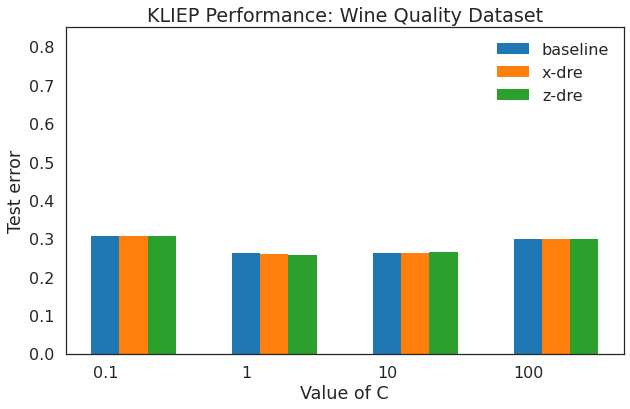

In [19]:
width = 0.2
plt.figure(figsize=(10,6))
for i, c in enumerate(Cs):
    labels = ['baseline', 'x-dre', 'z-dre'] if i == 0 else [None, None, None]
    
    plt.bar(i, baseline_errs[c],  width, label=labels[0], color=u'#1f77b4')
    plt.bar(i + width,  x_errs[c], width, label=labels[1], color=u'#ff7f0e')
    plt.bar(i + 2*width,  z_errs[c], width, label=labels[2], color=u'#2ca02c')

plt.xticks(np.arange(4), Cs)
plt.xlabel('Value of C')
plt.ylabel('Test error')
plt.ylim(0, 0.85)

plt.title('KLIEP Performance: Wine Quality Dataset')
plt.legend()
plt.show()